# Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

## Dataset

In this homework, we will use the Laptops price dataset from [Kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
```

The goal of this homework is to create a regression model for predicting the prices (column `'Final Price'`).


## Preparing the dataset 

First, we'll normalize the names of the columns:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Now, instead of `'Final Price'`, we have `'final_price'`.

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("laptops.csv")
df.columns = df.columns.str.lower().str.replace(' ', '_')
features = ["ram", "storage", "screen"]
target = "final_price"
df = df[features + [target]]

## EDA

* Look at the `final_price` variable. Does it have a long tail? 

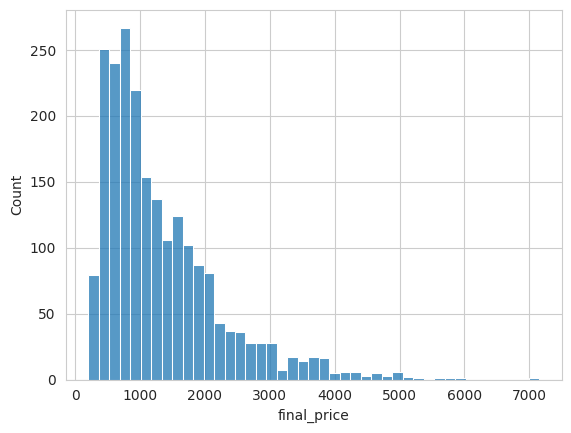

In [3]:
sns.histplot(data=df, x="final_price")
plt.show()

## Question 1

There's one column with missing values. What is it?

In [4]:
print(f"The column with missing values is {df.columns[df.isnull().sum() > 0][0]}")

The column with missing values is screen


### Question 2

What's the median (50% percentile) for variable `'ram'`?

In [5]:
print(f"The median (50% percentile) for variable 'ram' is {df['ram'].median()}")

The median (50% percentile) for variable 'ram' is 16.0


## Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [6]:
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

## Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [7]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [8]:
y_train = df_train[target]
y_val = df_val[target]
X_train1 = df_train[features].copy()
X_train1["screen"] = X_train1["screen"].fillna(0)
X_train2 = df_train[features].copy()
X_train2["screen"] = X_train2["screen"].fillna(X_train2["screen"].mean())
X_val1 = df_val[features].copy()
X_val1["screen"] = X_val1["screen"].fillna(0)
X_val2 = df_val[features].copy()
X_val2["screen"] = X_val2["screen"].fillna(X_train2["screen"].mean())

w0_1, w_1 = train_linear_regression(X_train1, y_train)
y_pred_1 = w0_1 + X_val1 @ w_1
score1 = round(root_mean_squared_error(y_val, y_pred_1), 2)
w0_2, w_2 = train_linear_regression(X_train2, y_train)
y_pred_2 = w0_2 + X_val2 @ w_2
score2 = round(root_mean_squared_error(y_val, y_pred_2), 2)

if score1 < score2:
    print("Fill missing value with 0 is better.")
elif score1 > score2:
    print("Fill missing value with mean is better.")
else:
    print("Both are equally good")

Fill missing value with 0 is better.


## Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [9]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [10]:
y_train = df_train[target]
y_val = df_val[target]
X_train = df_train[features].copy()
X_train["screen"] = X_train["screen"].fillna(0)
X_val = df_val[features].copy()
X_val["screen"] = X_val["screen"].fillna(0)

alphas = [0, 0.01, 0.1, 1, 10, 100]
scores = []
for r in alphas:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w0 + X_val @ w
    rmse = round(root_mean_squared_error(y_val, y_pred), 2)
    scores.append(rmse)

r = alphas[np.argmin(scores)]
print(f"{r=} gives the best RMSE")

r=10 gives the best RMSE


## Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [11]:
seeds = np.arange(10)
scores = []
for seed in seeds:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]].copy().fillna(0)
    df_val = df.iloc[idx[n_train:n_train+n_val]].copy().fillna(0)
    X_train = df_train[features]
    X_val = df_val[features]
    y_train = df_train[target]
    y_val = df_val[target]
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val @ w
    rmse = root_mean_squared_error(y_val, y_pred)
    scores.append(rmse)

std = np.std(scores)
print(f"The value of std is {round(std, 3)}")    

The value of std is 29.176


## Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [12]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
df_train = df.iloc[idx[:-n_test]].copy().fillna(0)
df_test = df.iloc[idx[-n_test:]].copy().fillna(0)
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train[target]
y_test = df_test[target]

w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w0 + X_test @ w
rmse = root_mean_squared_error(y_test, y_pred)
print(f"The RMSE on the test dataset is {round(rmse, 2)}")

The RMSE on the test dataset is 608.61


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw02
* If your answer doesn't match options exactly, select the closest one